In [25]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('df_metrics_CGM_biochem_demographics_extval.csv')

# Display basic info about the dataframe
print(f"DataFrame shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"First few rows:")
print(df.head())

DataFrame shape: (200, 37)
Columns: ['PtID', 'slope_TIR_per_day', 'slope_mean_glucose_per_day', 'glucose_p10', 'glucose_p25', 'glucose_p50', 'glucose_p75', 'glucose_p90', 'rolling_mean_std', 'rolling_cv_std', 'MAGE', 'MODD', 'CONGA_4', 'hypo_count', 'hyper_count', 'avg_hypo_duration', 'avg_hyper_duration', 'TIR_day', 'TIR_night', 'TBR_day', 'TBR_night', 'CV_day', 'CV_night', 'rapid_spike_count', 'slope_CV_interaction', 'Gender', 'Ethnicity', 'Race', 'EduLevel', 'EduLevelNoAns', 'EduLevelUnk', 'AnnualInc', 'C-Peptide', 'Glucose', 'HbA1c', 'Serum Creatinine', 'Hypertension']
First few rows:
   PtID  slope_TIR_per_day  slope_mean_glucose_per_day  glucose_p10  \
0   1.0          -0.021325                    6.072068         75.6   
1   2.0          -0.019459                    0.969768         69.0   
2   3.0          -0.010997                    3.050239        120.0   
3   4.0           0.007940                    0.426055         68.3   
4   5.0          -0.001418                    0.2

In [26]:
print("Class distribution:")
print(df['Hypertension'].value_counts()) 

Class distribution:
Hypertension
1    124
0     76
Name: count, dtype: int64


In [27]:
print("Missing values per column:")
print(df.isnull().sum().sort_values(ascending=False))

Missing values per column:
EduLevelUnk                   200
EduLevelNoAns                 198
AnnualInc                      25
MAGE                           15
EduLevel                        2
Glucose                         2
Serum Creatinine                2
C-Peptide                       2
glucose_p25                     0
PtID                            0
glucose_p10                     0
slope_mean_glucose_per_day      0
slope_TIR_per_day               0
hypo_count                      0
glucose_p50                     0
glucose_p90                     0
glucose_p75                     0
rolling_mean_std                0
rolling_cv_std                  0
MODD                            0
CONGA_4                         0
TBR_night                       0
TBR_day                         0
TIR_night                       0
TIR_day                         0
avg_hyper_duration              0
avg_hypo_duration               0
hyper_count                     0
CV_day               

In [29]:
df_clean = df.drop(columns=['EduLevelUnk',
'EduLevelNoAns',
'AnnualInc' ,
'MAGE'])

df_complete = df_clean.dropna()

print(f"Original dataframe shape: {df.shape}")
print(f"After dropping high-missing columns: {df_clean.shape}")
print(f"After keeping only complete cases: {df_complete.shape}")
print(f"Final patient count: {len(df_complete)}")

print("\nMissing values in final dataset:")
print(df_complete.isnull().sum().sum())  # Should be 0

Original dataframe shape: (200, 37)
After dropping high-missing columns: (200, 33)
After keeping only complete cases: (196, 33)
Final patient count: 196

Missing values in final dataset:
0


In [30]:
patients_with_hypertension_issue = df_complete[df_complete['Hypertension'] == 1]['PtID']

patients_list = patients_with_lipid_issue.tolist()

print(len(patients_list))
print(df_complete.columns.tolist())

110
['PtID', 'slope_TIR_per_day', 'slope_mean_glucose_per_day', 'glucose_p10', 'glucose_p25', 'glucose_p50', 'glucose_p75', 'glucose_p90', 'rolling_mean_std', 'rolling_cv_std', 'MODD', 'CONGA_4', 'hypo_count', 'hyper_count', 'avg_hypo_duration', 'avg_hyper_duration', 'TIR_day', 'TIR_night', 'TBR_day', 'TBR_night', 'CV_day', 'CV_night', 'rapid_spike_count', 'slope_CV_interaction', 'Gender', 'Ethnicity', 'Race', 'EduLevel', 'C-Peptide', 'Glucose', 'HbA1c', 'Serum Creatinine', 'Hypertension']


In [31]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

def run_cross_validation_xgboost_hypertension(df, target_col='Hypertension', n_splits=10, random_state=42):
    """
    Cross-validation using XGBoost for Hypertension prediction.
    """

    # One-hot encode categorical columns
    categorical_cols = ['Gender', 'Ethnicity', 'Race', 'EduLevel']
    df = pd.get_dummies(df, columns=[c for c in categorical_cols if c in df.columns], drop_first=True)

    # CGM metrics present in your dataset
    cgm_metrics = [
        'slope_TIR_per_day', 'slope_mean_glucose_per_day', 'glucose_p10', 'glucose_p25', 'glucose_p50', 'glucose_p75', 'glucose_p90', 'rolling_mean_std', 'rolling_cv_std', 'MODD', 'CONGA_4', 'hypo_count', 'hyper_count', 'avg_hypo_duration', 'avg_hyper_duration', 'TIR_day', 'TIR_night', 'TBR_day', 'TBR_night', 'CV_day', 'CV_night', 'rapid_spike_count', 'slope_CV_interaction'
    ]

    # Baseline features: everything except PtID, target, and CGM
    X_base = df.drop(columns=['PtID', target_col] + cgm_metrics, errors='ignore')

    # Full datasets
    X_all = pd.concat([X_base, df[cgm_metrics]], axis=1)
    X_only_cgm = df[cgm_metrics]
    X_no_cgm = X_base
    y = df[target_col]

    # Results dictionary
    results = {
        'with_cgm': {'roc_auc': [], 'pr_auc': [], 'models': [], 'y_true_folds': [], 'y_pred_folds': []},
        'without_cgm': {'roc_auc': [], 'pr_auc': [], 'models': [], 'y_true_folds': [], 'y_pred_folds': []},
        'only_cgm': {'roc_auc': [], 'pr_auc': [], 'models': [], 'y_true_folds': [], 'y_pred_folds': []}
    }

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (train_idx, test_idx) in enumerate(skf.split(X_all, y), 1):
        # Train/test splits
        X_train_all, X_test_all = X_all.iloc[train_idx], X_all.iloc[test_idx]
        X_train_no_cgm, X_test_no_cgm = X_no_cgm.iloc[train_idx], X_no_cgm.iloc[test_idx]
        X_train_only, X_test_only = X_only_cgm.iloc[train_idx], X_only_cgm.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Scale numeric columns
        scaler_all = StandardScaler().fit(X_train_all)
        scaler_no_cgm = StandardScaler().fit(X_train_no_cgm)
        scaler_only = StandardScaler().fit(X_train_only)

        X_train_all_scaled = scaler_all.transform(X_train_all)
        X_test_all_scaled = scaler_all.transform(X_test_all)
        X_train_no_cgm_scaled = scaler_no_cgm.transform(X_train_no_cgm)
        X_test_no_cgm_scaled = scaler_no_cgm.transform(X_test_no_cgm)
        X_train_only_scaled = scaler_only.transform(X_train_only)
        X_test_only_scaled = scaler_only.transform(X_test_only)

        # SMOTE
        smote = SMOTE(random_state=random_state + fold)
        X_train_all_smote, y_train_all_smote = smote.fit_resample(X_train_all_scaled, y_train)
        X_train_no_cgm_smote, y_train_no_cgm_smote = smote.fit_resample(X_train_no_cgm_scaled, y_train)
        X_train_only_smote, y_train_only_smote = smote.fit_resample(X_train_only_scaled, y_train)

        # XGBoost parameters
        model_params = {
            'n_estimators': 500,
            'max_depth': 3,
            'learning_rate': 0.1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'eval_metric': 'logloss',
            'use_label_encoder': False,
            'random_state': random_state
        }

        # Fit models
        models = {
            'with_cgm': xgb.XGBClassifier(**model_params).fit(X_train_all_smote, y_train_all_smote),
            'without_cgm': xgb.XGBClassifier(**model_params).fit(X_train_no_cgm_smote, y_train_no_cgm_smote),
            'only_cgm': xgb.XGBClassifier(**model_params).fit(X_train_only_smote, y_train_only_smote)
        }

        # Predict & store metrics
        for key, X_test_scaled in zip(['with_cgm','without_cgm','only_cgm'],
                                      [X_test_all_scaled, X_test_no_cgm_scaled, X_test_only_scaled]):
            y_pred = models[key].predict_proba(X_test_scaled)[:,1]
            results[key]['models'].append(models[key])
            results[key]['y_true_folds'].append(y_test.values)
            results[key]['y_pred_folds'].append(y_pred)

            # Metrics
            results[key]['roc_auc'].append(roc_auc_score(y_test, y_pred))
            precision, recall, _ = precision_recall_curve(y_test, y_pred)
            results[key]['pr_auc'].append(auc(recall, precision))

        print(f"Fold {fold:2d}: "
              f"With={results['with_cgm']['roc_auc'][-1]:.3f}, "
              f"Without={results['without_cgm']['roc_auc'][-1]:.3f}, "
              f"Only={results['only_cgm']['roc_auc'][-1]:.3f}")

    return results, X_all.columns.tolist(), X_no_cgm.columns.tolist(), X_only_cgm.columns.tolist()

In [80]:
seeds = [2026, 99, 101, 105]
df_complete['C-Peptide'] = df_complete['C-Peptide'].astype(str).str.replace('<', '').astype(float)

In [81]:
conditions = ['Hypertension']

all_results = {}

for condition in conditions:
    all_results[condition] = {}
    
    for seed in seeds:
        try:
            results, features_with, features_without, features_only = run_cross_validation_xgboost_hypertension(
                df_complete,
                target_col=condition,
                n_splits=10,
                random_state=seed
            )
            
            all_results[condition][seed] = results
            
            # Summary of ROC-AUC
            print(f"{condition} | Seed {seed} - Cross-validation complete")
            print(f"  ROC-AUC With CGM: {np.mean(results['with_cgm']['roc_auc']):.3f} ± {np.std(results['with_cgm']['roc_auc']):.3f}")
            print(f"  ROC-AUC Without CGM: {np.mean(results['without_cgm']['roc_auc']):.3f} ± {np.std(results['without_cgm']['roc_auc']):.3f}")
            print(f"  ROC-AUC Only CGM: {np.mean(results['only_cgm']['roc_auc']):.3f} ± {np.std(results['only_cgm']['roc_auc']):.3f}")
            print(f"  Features: With CGM = {len(features_with)}, Without CGM = {len(features_without)}, Only CGM = {len(features_only)}\n")
            
        except Exception as e:
            print(f"Error processing {condition} with seed {seed}: {e}")
            continue

Fold  1: With=0.791, Without=0.637, Only=0.681
Fold  2: With=0.593, Without=0.473, Only=0.593
Fold  3: With=0.396, Without=0.573, Only=0.552
Fold  4: With=0.167, Without=0.281, Only=0.271
Fold  5: With=0.375, Without=0.448, Only=0.458
Fold  6: With=0.458, Without=0.417, Only=0.490
Fold  7: With=0.786, Without=0.595, Only=0.679
Fold  8: With=0.548, Without=0.488, Only=0.369
Fold  9: With=0.690, Without=0.679, Only=0.571
Fold 10: With=0.405, Without=0.381, Only=0.452
Hypertension | Seed 2026 - Cross-validation complete
  ROC-AUC With CGM: 0.521 ± 0.189
  ROC-AUC Without CGM: 0.497 ± 0.117
  ROC-AUC Only CGM: 0.512 ± 0.124
  Features: With CGM = 44, Without CGM = 21, Only CGM = 23

Fold  1: With=0.780, Without=0.527, Only=0.648
Fold  2: With=0.484, Without=0.560, Only=0.505
Fold  3: With=0.312, Without=0.417, Only=0.375
Fold  4: With=0.802, Without=0.615, Only=0.656
Fold  5: With=0.573, Without=0.594, Only=0.594
Fold  6: With=0.500, Without=0.385, Only=0.469
Fold  7: With=0.679, Without=0

In [82]:
from scipy.stats import ttest_rel

conditions = [
    'Hypertension'
]

models = ['without_cgm', 'with_cgm']
model_labels = {
    'without_cgm': 'Biochemical only',
    'with_cgm': 'Biochemical + CGM'
}

metrics_to_display = ['roc_auc', 'pr_auc']
alpha = 0.05  # significance level

# ---------------------------
# Build summary tables with significance
# ---------------------------
summary_tables = {}

for metric in metrics_to_display:
    table_data = []
    for condition in conditions:
        seeds_results = all_results[condition]  # dict: seed -> results
        values_biochem = []
        values_biochem_cgm = []
        prevalence_count = 0
        total_count = 0

        # Collect all fold values across seeds
        for seed_res in seeds_results.values():
            values_biochem.extend(seed_res['without_cgm'][metric])
            values_biochem_cgm.extend(seed_res['with_cgm'][metric])

            # Compute prevalence only once per seed (assumes y_true_folds all same length)
            y_all = np.concatenate(seed_res['with_cgm']['y_true_folds'])
            prevalence_count += np.sum(y_all)
            total_count += len(y_all)

        # Compute prevalence for this condition (average across seeds)
        prevalence = prevalence_count / total_count if metric == 'pr_auc' else None

        # Mean ± std for each model
        mean_biochem = np.mean(values_biochem)
        std_biochem = np.std(values_biochem, ddof=1)
        mean_cgm = np.mean(values_biochem_cgm)
        std_cgm = np.std(values_biochem_cgm, ddof=1)

        # One-sided paired t-test: H0 = CGM does not improve, H1 = CGM improves
        t_stat, p_two_sided = ttest_rel(values_biochem_cgm, values_biochem)
        p_one_sided = p_two_sided / 2 if t_stat > 0 else 1 - p_two_sided / 2
        signif = '*' if p_one_sided < alpha else ''

        row = {
            'Comorbidity': condition,
            model_labels['without_cgm']: f"{mean_biochem:.3f} ± {std_biochem:.3f}",
            model_labels['with_cgm']: f"{mean_cgm:.3f} ± {std_cgm:.3f}",
            'p-value': f"{p_one_sided:.4f}",
            'Significance': signif
        }

        # Add prevalence column only for PR AUC
        if metric == 'pr_auc':
            row['Prevalence'] = f"{prevalence:.3f}"

        table_data.append(row)

    # Create DataFrame with comorbidity as index
    df_metric = pd.DataFrame(table_data).set_index('Comorbidity')
    summary_tables[metric] = df_metric

# ---------------------------
# Display tables
# ---------------------------
for metric, df_table in summary_tables.items():
    print(f"\n=== {metric.upper()} SUMMARY WITH STATISTICAL TESTING ===")
    display(df_table)


=== ROC_AUC SUMMARY WITH STATISTICAL TESTING ===


,Biochemical only,Biochemical + CGM,p-value,Significance
Comorbidity,,,,
Hypertension,0.530 ± 0.114,0.551 ± 0.154,0.1470,



=== PR_AUC SUMMARY WITH STATISTICAL TESTING ===


,Biochemical only,Biochemical + CGM,p-value,Significance,Prevalence
Comorbidity,,,,,
Hypertension,0.668 ± 0.094,0.679 ± 0.114,0.2742,,0.622


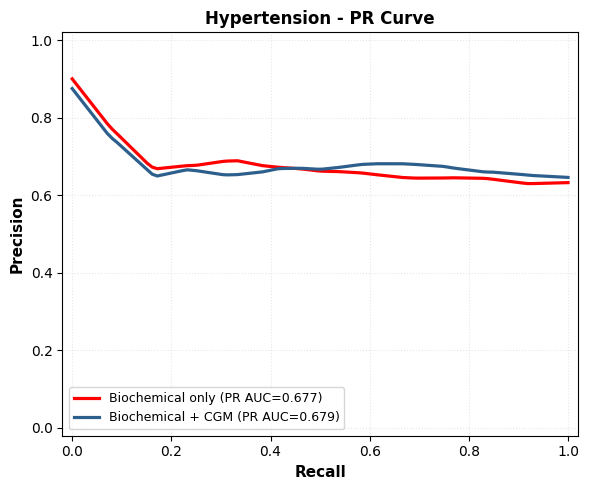

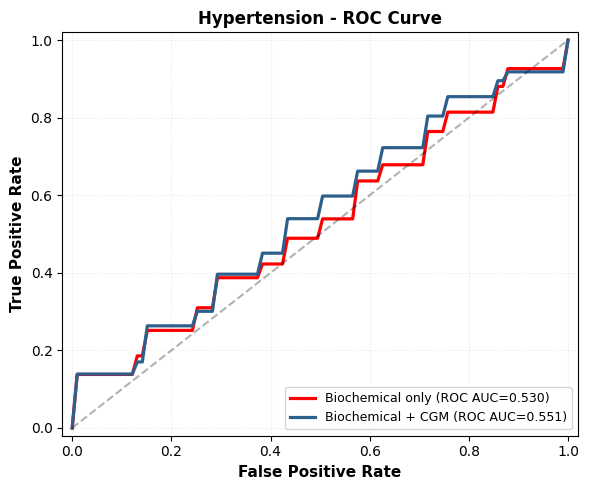

In [83]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, auc, roc_curve

# ---------------------------
# Functions to compute mean curves
# ---------------------------
def mean_pr_curve(y_trues_list, y_preds_list, n_points=100):
    """Compute mean PR curve across folds/seeds."""
    precisions = []
    mean_recall = np.linspace(0, 1, n_points)
    
    for y_true, y_pred in zip(y_trues_list, y_preds_list):
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
        # Sort and remove duplicates
        sorted_idx = np.argsort(recall)
        recall_sorted = recall[sorted_idx]
        precision_sorted = precision[sorted_idx]
        unique_recall, idx = np.unique(recall_sorted, return_index=True)
        unique_precision = precision_sorted[idx]
        # Interpolate
        precisions.append(np.interp(mean_recall, unique_recall, unique_precision))
    
    mean_precision = np.mean(precisions, axis=0)
    mean_auc = auc(mean_recall, mean_precision)
    return mean_recall, mean_precision, mean_auc

def mean_roc_curve(y_trues_list, y_preds_list, n_points=100):
    """Compute mean ROC curve across folds/seeds."""
    tprs = []
    mean_fpr = np.linspace(0, 1, n_points)
    
    for y_true, y_pred in zip(y_trues_list, y_preds_list):
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    return mean_fpr, mean_tpr, mean_auc

# ---------------------------
# Plotting both PR and ROC curves per comorbidity
# ---------------------------
conditions = [
    'Hypertension'
]

model_types = ['without_cgm', 'with_cgm']
model_labels = {
    'without_cgm': 'Biochemical only',
    'with_cgm': 'Biochemical + CGM'
}
colors = {
    'without_cgm': 'red',
    'with_cgm': '#2d5f8d'
}

for condition in conditions:
    results = all_results[condition]  # dict keyed by seed
    y_trues_all = {m: [] for m in model_types}
    y_preds_all = {m: [] for m in model_types}

    # Aggregate across seeds
    for seed in results:
        for m in model_types:
            y_trues_all[m].extend(results[seed][m]['y_true_folds'])
            y_preds_all[m].extend(results[seed][m]['y_pred_folds'])

    # ---- PR Curve ----
    plt.figure(figsize=(6, 5))
    for m in model_types:
        mean_recall, mean_precision, mean_auc = mean_pr_curve(y_trues_all[m], y_preds_all[m])
        plt.plot(
            mean_recall, mean_precision,
            color=colors[m],
            linewidth=2.3,
            label=f"{model_labels[m]} (PR AUC={mean_auc:.3f})"
        )
    plt.xlabel('Recall', fontsize=11, fontweight='bold')
    plt.ylabel('Precision', fontsize=11, fontweight='bold')
    plt.title(f'{condition} - PR Curve', fontsize=12, fontweight='bold')
    plt.legend(loc='lower left', fontsize=9)
    plt.grid(alpha=0.3, linestyle=':')
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.tight_layout()
    plt.show()

    # ---- ROC Curve ----
    plt.figure(figsize=(6, 5))
    for m in model_types:
        mean_fpr, mean_tpr, mean_auc = mean_roc_curve(y_trues_all[m], y_preds_all[m])
        plt.plot(
            mean_fpr, mean_tpr,
            color=colors[m],
            linewidth=2.3,
            label=f"{model_labels[m]} (ROC AUC={mean_auc:.3f})"
        )
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)  # diagonal
    plt.xlabel('False Positive Rate', fontsize=11, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=11, fontweight='bold')
    plt.title(f'{condition} - ROC Curve', fontsize=12, fontweight='bold')
    plt.legend(loc='lower right', fontsize=9)
    plt.grid(alpha=0.3, linestyle=':')
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.tight_layout()
    plt.show()